Let's first get the content of the page that has the ACTUAL form. Which is: http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247 This form is loaded on the actual page using AJAX - which we will not be using at all.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
%matplotlib inline  
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy

In [2]:
resp = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247')
resp.status_code

200

Good Resource for Beautiful soup: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
### Getting available parameters from the form
We will need them later. Let's extract them from the HTML using beautifulsoup.

In [3]:
from bs4 import BeautifulSoup
from pprint import pprint as pp
intro_page_soup = BeautifulSoup(resp.text, 'html.parser')

# We examined the html page that includes the form by doing some requests and inspecting the query
# Parameters using Postman and google chrome's debugger, and we realized that we only need 
# ww_x_PERIODE_ACAD, ww_x_PERIODE_PEDAGO


year_options_soups = intro_page_soup.find('select', {'name': 'ww_x_PERIODE_ACAD'}).find_all('option')
year_options = [
    (option['value'], int(option.text.split('-')[0])) for option in year_options_soups if option.text
]

semester_options_soups = intro_page_soup.find('select', {'name': 'ww_x_PERIODE_PEDAGO'}).find_all('option')
semester_options = [
    (option['value'], option.text) for option in semester_options_soups if option.text
]

print("Year Options:")
pp(year_options)

print("Semester Options:")
pp(semester_options)

Year Options:
[('355925344', 2016),
 ('213638028', 2015),
 ('213637922', 2014),
 ('213637754', 2013),
 ('123456101', 2012),
 ('123455150', 2011),
 ('39486325', 2010),
 ('978195', 2009),
 ('978187', 2008),
 ('978181', 2007)]
Semester Options:
[('249108', 'Bachelor semestre 1'),
 ('249114', 'Bachelor semestre 2'),
 ('942155', 'Bachelor semestre 3'),
 ('942163', 'Bachelor semestre 4'),
 ('942120', 'Bachelor semestre 5'),
 ('2226768', 'Bachelor semestre 5b'),
 ('942175', 'Bachelor semestre 6'),
 ('2226785', 'Bachelor semestre 6b'),
 ('2230106', 'Master semestre 1'),
 ('942192', 'Master semestre 2'),
 ('2230128', 'Master semestre 3'),
 ('2230140', 'Master semestre 4'),
 ('2335667', 'Mineur semestre 1'),
 ('2335676', 'Mineur semestre 2'),
 ('2063602308', 'Mise à niveau'),
 ('249127', 'Projet Master automne'),
 ('3781783', 'Projet Master printemps'),
 ('953159', 'Semestre automne'),
 ('2754553', 'Semestre printemps'),
 ('953137', 'Stage automne 3ème année'),
 ('2226616', 'Stage automne 4ème a

In [4]:

base_payload = {
    'ww_x_GPS': -1,
    'ww_i_reportModel': 133685247,
    'ww_i_reportModelXsl': 133685270,
    'ww_x_UNITE_ACAD': 249847, #ID of Informatique Department
    'ww_x_PERIODE_ACAD': 213637754, # we will change this (Using YEARS options)
    'ww_x_PERIODE_PEDAGO': 249108, #we will change this (Using SEMESTERS options)
    'ww_x_HIVERETE': 'null' #? well this was there - better not touch - works fine like this..
}

# Exercise 1: Bachelor Students

## 1.1. Extracting Bachelor Data and Computing Duration: 

In what follows, we load the data for all students registered in Bachelor Semester 1, Bachelor Semester 5 and Bachelor Semester 6 from 2007 to 2016. We include Bachelor Semester 5 here because it is possible to have students who take semester 5 and fail it but can do semester 6 and redo courses from semester 5 next year without redoing semester 6, which doesn't apply if students fail Semester 1 or 2 as they need to repeat the whole year ( both Semester 1 and 2) and same thing holds for failing semester 3 or 4 which implies repeating the whole year. For each student, we keep a record of years in which he/she did or redid Bachelor Semester 1, Bachelor Semester 5 and Bachelor Semester 6. At this stage, we don't remove duplicates yet.

In [5]:
import pandas as pd
import concurrent.futures
import itertools


bachelors_final_table = None # The data frame that holds the data for student registrations for all years and the 3 semesters

# This function takes as argument semester_tuple (both name and numerical value to be passed as value of http request parameter ww_x_PERIODE_PEDAGO ) 
# and year_tuple (both name and numerical value to be passed as value of http request parameter ww_x_PERIODE_ACAD)
# and gives as a result the name of the table with all registrations corresponding to those 
# year and semester values
def grab_table(semester_tuple, year_tuple):
    year_value,year_int = year_tuple
    semester_value, semester_col = semester_tuple
    payload = dict(base_payload) # we load the static parameters filled in previous parts needed to make the http request
    payload['ww_x_PERIODE_ACAD'] = year_value 
    payload['ww_x_PERIODE_PEDAGO'] = semester_value 
    # we pass the payload as parameters to the http request
    resp = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html', params = payload)
    try:
        # We get the corresponding html table using read_html function
        table = pd.read_html(resp.text, header=1)[0][['Civilité', 'Nom Prénom', 'Statut', 'No Sciper', 'Spécialisation']]
    except:
        return None
    table[semester_col] = year_int
    table['No Sciper'] = table['No Sciper'].astype(str)
    table.set_index(['No Sciper'], inplace=True, drop=False)
    print(semester_col, year_int,"done")
    return table
    
semester_tuples = [('249108', 'Semester 1'), ('942120', 'Semester 5'),('942175', 'Semester 6')]
year_tuples = year_options

# Here we make use of threads to enable concurrent reading and filling of data corresponding 
# to each semester and year and we itertools to automatically iterate over all possible 
# combination of semesters and years
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    frames = executor.map(lambda x: grab_table(*x), itertools.product(semester_tuples, year_tuples))
    
print("Finished")

# We filter out empty frames
frames = filter(lambda x : x is not None, frames)
# We merge all frames into one data frame 
for frame in frames:
    if bachelors_final_table is None:
        bachelors_final_table = frame
    else:
        bachelors_final_table = pd.merge(frame, bachelors_final_table, how='outer')

bachelors_final_table.head()

Semester 1 2009 done
Semester 1 2007 done
Semester 1 2008 done
Semester 1 2011 done
Semester 1 2015 done
Semester 1 2010 done
Semester 1 2016 done
Semester 1 2012 done
Semester 1 2013 done
Semester 1 2014 done
Semester 5 2016 done
Semester 5 2013 done
Semester 5 2015 done
Semester 5 2014 done
Semester 5 2010 done
Semester 5 2008 done
Semester 5 2007 done
Semester 5 2009 done
Semester 5 2012 done
Semester 6 2013 done
Semester 6 2014 done
Semester 6 2011 done
Semester 6 2015 done
Semester 6 2010 done
Semester 6 2008 done
Semester 6 2007 done
Semester 6 2009 done
Semester 6 2012 done
Semester 5 2011 done
Semester 6 2016 done
Finished


,Civilité,Nom Prénom,Statut,No Sciper,Spécialisation,Semester 6,Semester 5,Semester 1
0,Monsieur,Barras Florian,Présent,170220,NaN,2007.0,NaN,NaN
1,Monsieur,Beuret Thibaut,Présent,166701,NaN,2007.0,NaN,NaN
2,Monsieur,Biollay Jean Isaac Jamal Pachacutec,Présent,161279,NaN,2007.0,NaN,NaN
3,Monsieur,Blatter Jérémy,Présent,166344,NaN,2007.0,NaN,NaN
4,Monsieur,Boksanyi Michael,Présent,161634,NaN,2007.0,NaN,NaN


In this part, we compute the durations for each student identified by a unique Sciper number. We start by doing some data cleaning by removing students for which there is no entry for Bachelor Semester 6 and Bachelor Semester 1. We chose not to deal with students who started their Bachelor recently in which case no entry for Bachelor Semester 6 is provided, and same for students who did their Bachelor a long time ago (took Bachelor Semester 1 before 2007) and for which we don't have complete data. 
We compute the starting year by looking at the first entry of Bachelor Semester 1 (in case the student repeated) which is the smallest year of the year values for Bachelor Semester 1.
We compute the ending year by looking at the last entry of Bachelor Semester 6 (in case the student repeated) which is the smallest year of the year values for Bachelor Semester 1. Now, we cover the edge case for which data for Bachelor Semester 5 will be used. In case a student takes Bachelor Semester 5, fails it, still takes Bachelor Semester 6 and passes it. Then to be able to graduate, he only needs to take Bachelor Semester 5 in which case we just add 6 extra months. The total duration is the number of years between the first Bachelor Semester 1 and the last Bachelor Semester 6 * 12 to convert to months + extra for the edge case.

In [6]:
def get_merged_(group):
    #Drop the groups (enrollment record of a single person) which doesn't include Semester 6 and Semester 1
    if len(group) > 1 and len(group.dropna(subset=['Semester 6'])) > 0 and len(group.dropna(subset=['Semester 1'])) > 0:
        ending = max(group[['Semester 6']].max(axis=0)) # ending year
        starting = min(group[['Semester 1']].min(axis=0)) # starting year
        
        semester_5_year = max(group[['Semester 5']].max(axis=0)) # edge case
        
        extra = 6 if semester_5_year > ending else 0 # add extra for edge case  
        return pd.DataFrame({
            "No Sciper": group.iloc[0]['No Sciper'],
            "duration": (ending-starting+1)*12 + extra, #months
            "gender": group.iloc[0]['Civilité']
        }, index=['No Sciper'])
    return pd.DataFrame([])

grouped = bachelors_final_table.groupby('No Sciper') 
filtered = grouped.apply(get_merged_) # We apply our function to add duration and gender columns for each sciper number

print(filtered.head()) # return first 5 rows for visualization 
print(filtered.describe()) #Here, we calculate count, mean, standard deviation, min, max and quartiles 

                    No Sciper  duration    gender
No Sciper                                        
147008    No Sciper    147008      36.0  Monsieur
169569    No Sciper    169569      36.0  Monsieur
169731    No Sciper    169731      48.0  Monsieur
169795    No Sciper    169795      54.0  Monsieur
171195    No Sciper    171195      36.0  Monsieur
         duration
count  397.000000
mean    42.725441
std      9.372089
min     36.000000
25%     36.000000
50%     36.000000
75%     48.000000
max     84.000000


## 1.2. Partitioning Data Between Male and Female Students and Computing the Average

Now, we calculate count, mean, standard deviation, min, max and quartiles for males and females durations.

In [7]:
filtered.groupby('gender').apply(lambda x: x.describe())

duration
gender                    
Madame   count   29.000000
         mean    40.758621
         std      8.078433
         min     36.000000
         25%     36.000000
         50%     36.000000
         75%     48.000000
         max     66.000000
Monsieur count  368.000000
         mean    42.880435
         std      9.458750
         min     36.000000
         25%     36.000000
         50%     36.000000
         75%     48.000000
         max     84.000000

Now, we visualize the histogram distributions for all students.

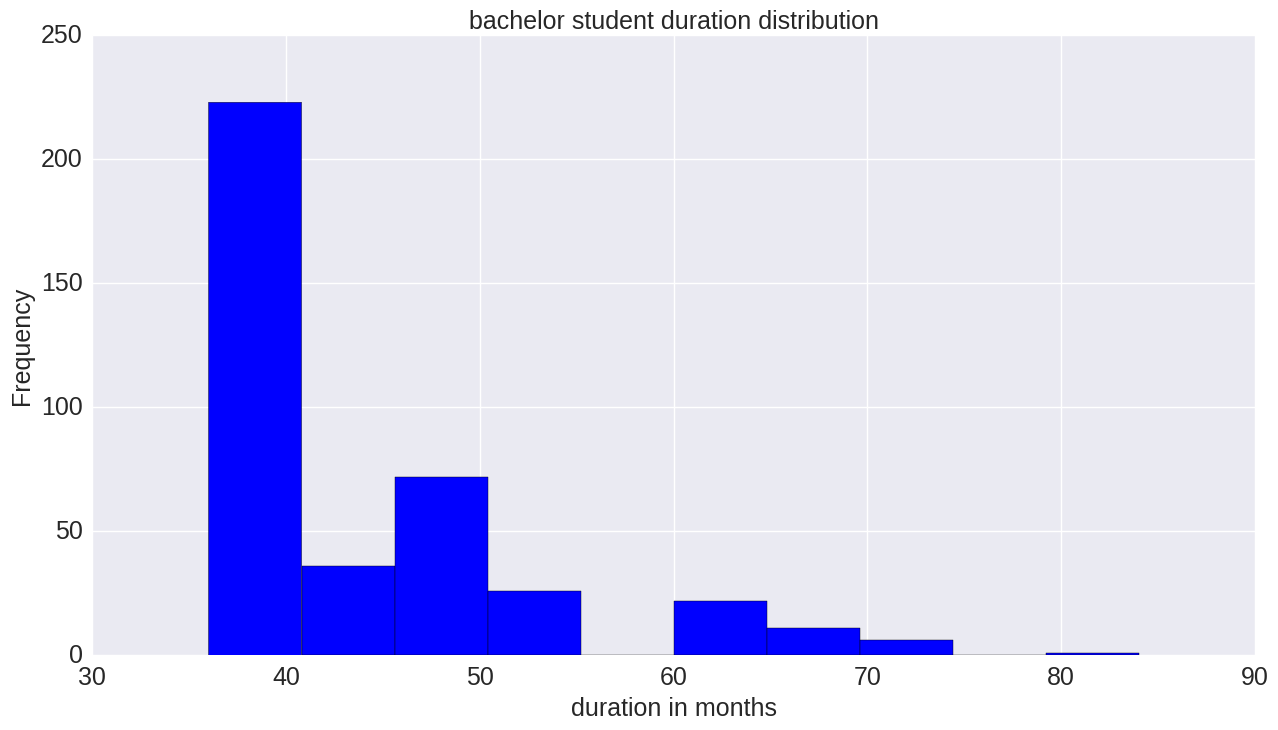

In [8]:
filtered.hist(column='duration', figsize=(15,8), color = 'blue')
plt.title('bachelor student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [9]:
madames_durations = filtered[filtered['gender'] == 'Madame']['duration']
monsieur_durations = filtered[filtered['gender'] == 'Monsieur']['duration']

We visualize the histogram distributions for all females and males.

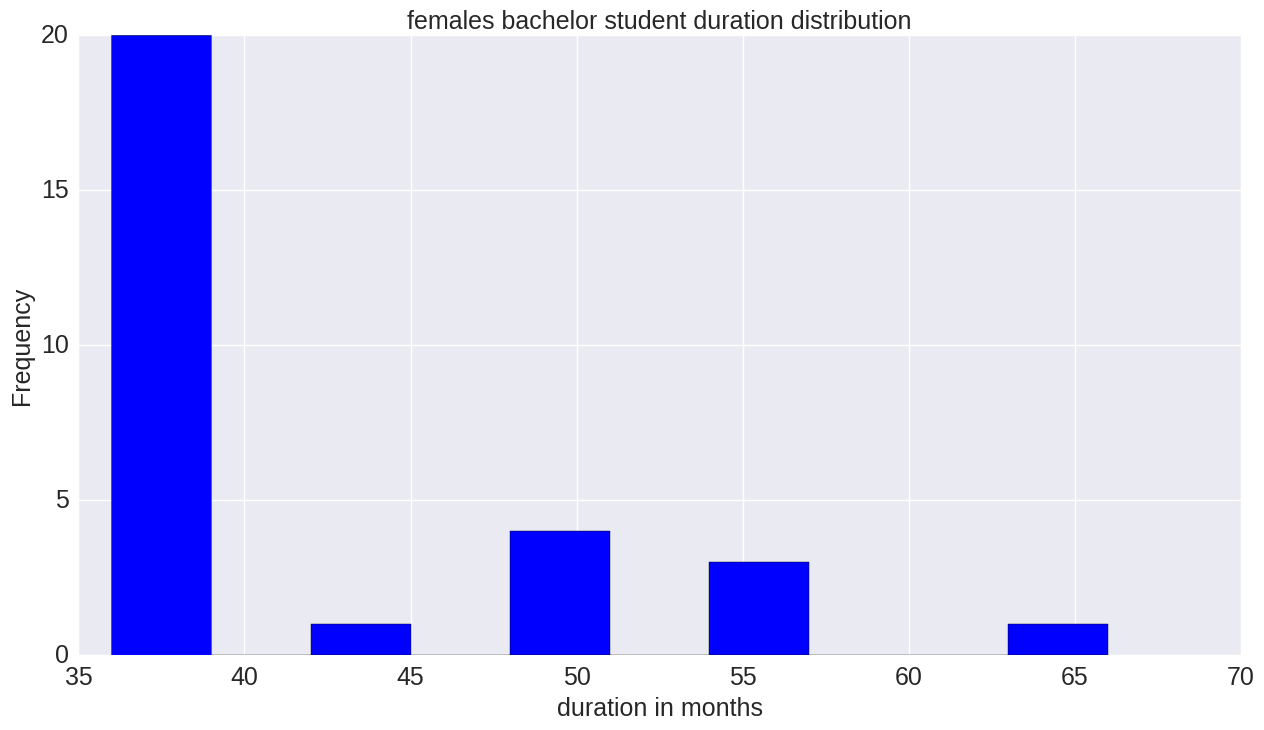

In [10]:
madames_durations.hist(figsize=(15,8), color = 'blue')
plt.title('females bachelor student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

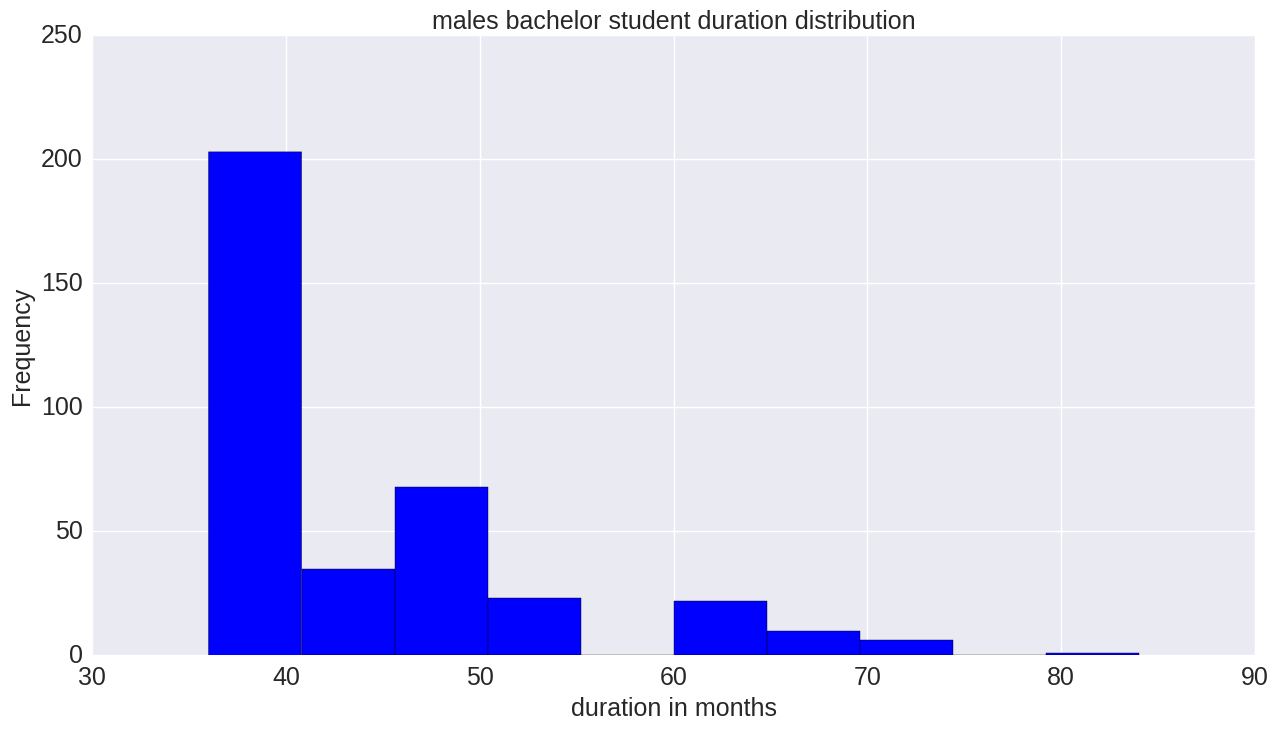

In [11]:
monsieur_durations.hist(figsize=(15,8), color = 'blue')
plt.title('males bachelor student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

This plot compares the mean for females and males. 

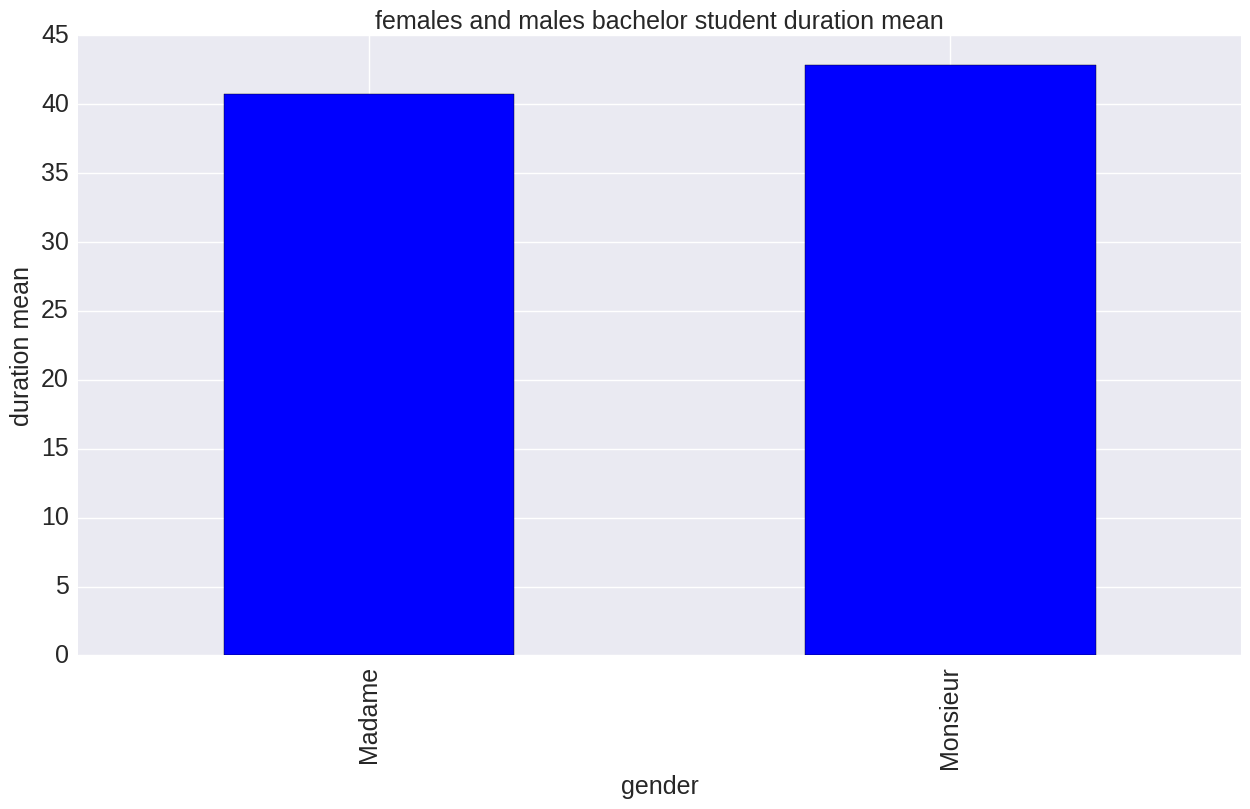

In [12]:
filtered.groupby('gender').duration.mean().plot(kind='bar', color='blue',figsize=(15,8))
plt.title('females and males bachelor student duration mean', fontsize=18)
plt.xlabel('gender', fontsize=18)
plt.ylabel('duration mean', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

## 1.3. Evaluating the Statistical Significance of the Difference between the two averages for males and females:

### Data Normalization and Standardization:
Normalization refers to rescaling real valued numeric attributes into the range 0 and 1 and standardization refers to shifting the distribution of each attribute to have a mean of zero and a standard deviation of one (unit variance). We need this to perform K-S test since this test checks whether a distribution is normal by comparing it to a standardized normalized distribution.

In [13]:
def normalize_standardize(distribution):
    distribution_norm = (distribution - distribution.mean()) / (distribution.max() - distribution.min())
    distribution_norm_stand = (distribution_norm - distribution_norm.mean()) / distribution_norm.std()
    return distribution_norm_stand

madames_norm_stand = normalize_standardize(madames_durations)
monsieur_norm_stand = normalize_standardize(monsieur_durations)

### Plotting distributions for Normalized, Standardized Data

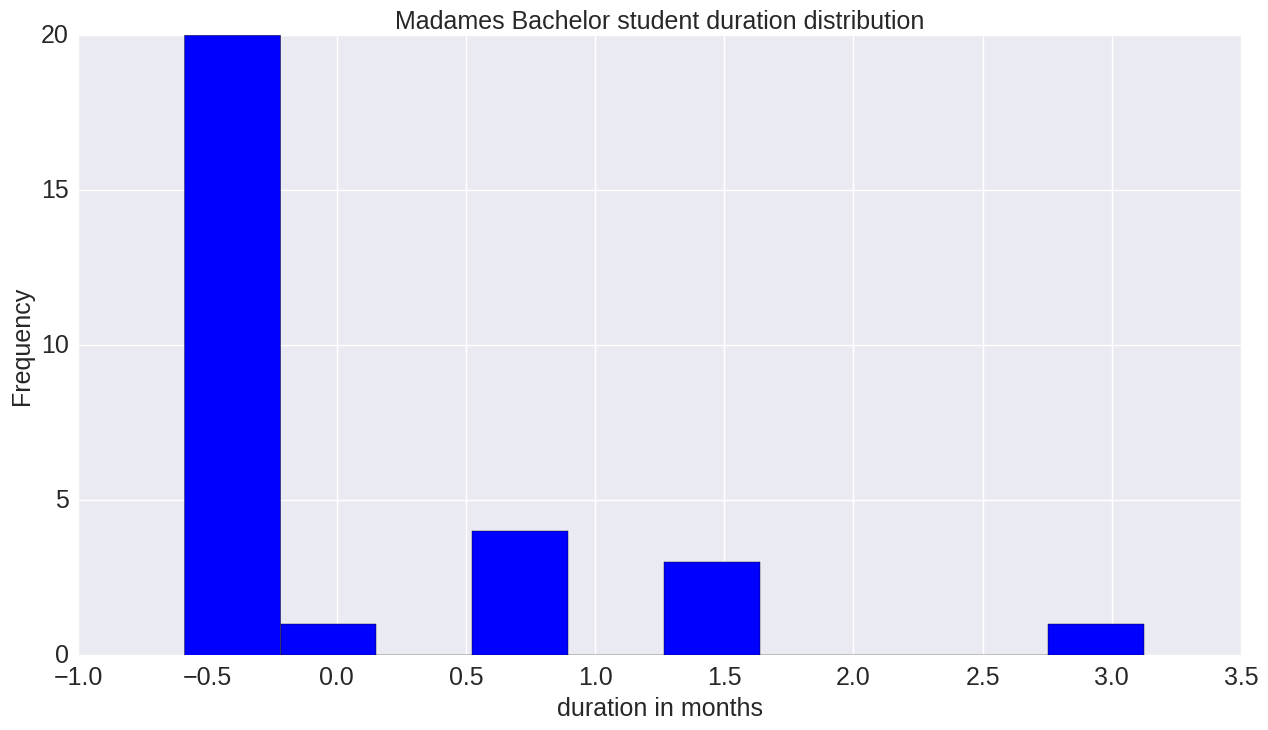

In [14]:
madames_norm_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Madames Bachelor student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

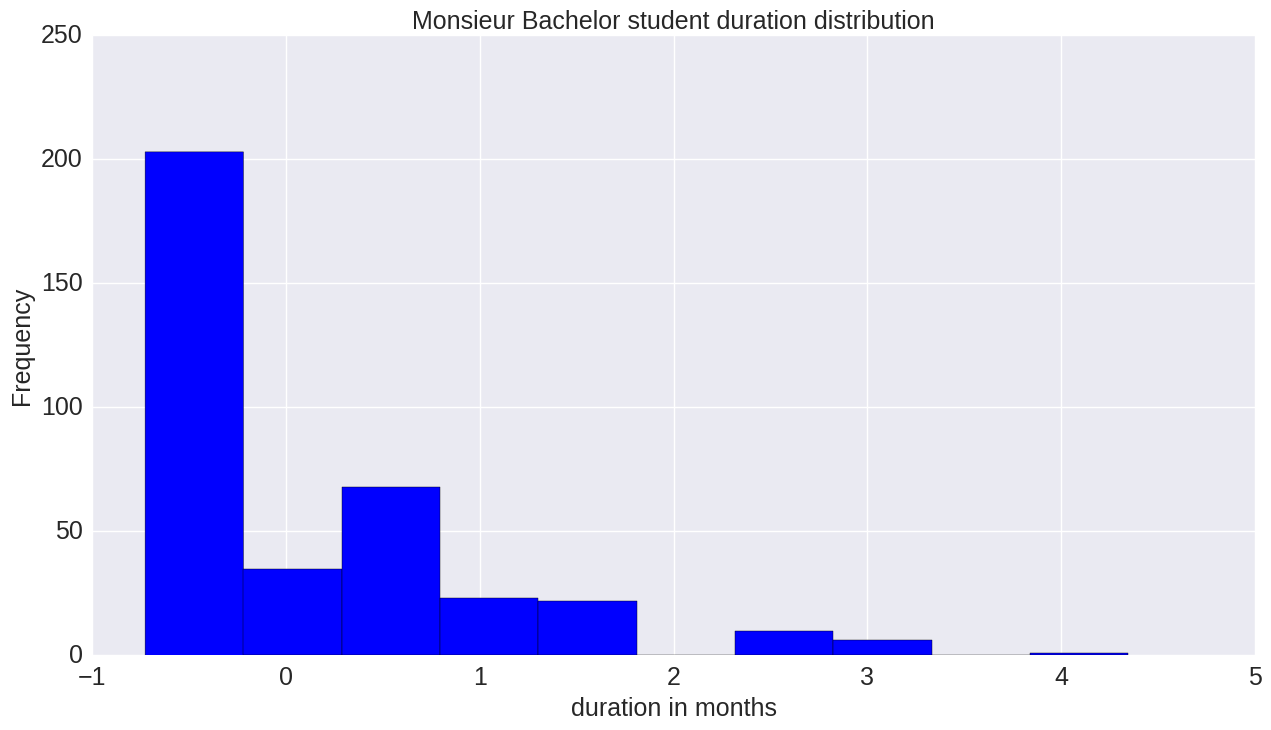

In [15]:
monsieur_norm_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Monsieur Bachelor student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

### K-S (Kolmorogorov-Smirnov) test to check for Normal Distribution

In [16]:
stats.kstest(madames_norm_stand,'norm')

KstestResult(statistic=0.41174211903114533, pvalue=5.8119180432525397e-05)

Since the kstest returns a pvalue=5.8119180432525397e-05 (extremely smaller than 5%), we can reject with high confidence the null hypothesis that says that the bachelor duration for madames is a normal distribution => madames_norm_stand is not normal.

In [17]:
stats.kstest(monsieur_norm_stand,'norm')

KstestResult(statistic=0.31814448768829573, pvalue=0.0)

Since the kstest returns a pvalue=0.0 (extremely smaller than 5%),we can reject with high confidence the null hypothesis that says that the bachelor duration for monsieur is a normal distribution => monsieur_norm_stand is not normal.

Since the two samples are not normal, and we have unpaired independent samples (since we want to compare two different subjects and there is no correlation between males and females the duration that it takes for males to graduate doesn't make the duration for females to graduate), the most adequate to apply here is Mann-Whitney test. We choose two tailed since we don't have any preference for a direction of the difference between the two samples (smaller/greater).

In [ ]:
stats.mannwhitneyu(madames_norm_stand, monsieur_norm_stand, use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=6876.0, pvalue=0.0052675951752590502)

Since pvalue=0.0052675951752590502 is less than the threshold of 5%, we can with a confidence greater than 95% reject the null hypothesis that says that the two samples have the same mean. So there is a significant statistical difference between males duration to graduate and females duration to graduate.

# Exercise 2: Masters Students

## 2.1. Extracting Master Data and Computing Duration

To prepare the big table for master's students, we fetch the following tables for each year.
* Semester 1
* Semester 2
* Semester 3
* Semester 4
* Master's Project autumn
* Master's Project spring

In [ ]:
master_semesters = [
    ('2230106', 'Master semestre 1'),
    ('942192', 'Master semestre 2'),
    ('2230128', 'Master semestre 3'),
    ('2230140', 'Master semestre 4'),
    ('249127', 'Projet Master automne'),
    ('3781783', 'Projet Master printemps'),
]

masters_final_table = None

#frames = map(lambda x: grab_table(*x), itertools.product(master_semesters, year_tuples))
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    master_frames = executor.map(lambda x: grab_table(*x), itertools.product(master_semesters, year_tuples))
print("Finished")
master_frames = filter(lambda x : x is not None, master_frames)
for frame in master_frames:
    if masters_final_table is None:
        masters_final_table = frame
    else:
        #bachelors_final_table = pd.merge(table[['No Sciper', semester_col]], bachelors_final_table, left_on='No Sciper', right_on='No Sciper', how='outer')
        masters_final_table = pd.merge(frame, masters_final_table, how='outer')

Master semestre 1 2009 done
Master semestre 1 2007 done
Master semestre 1 2010 done
Master semestre 1 2012 done
Master semestre 2 2016 done
Master semestre 1 2011 done
Master semestre 1 2014 done
Master semestre 1 2015 done
Master semestre 1 2016 done
Master semestre 1 2008 done
Master semestre 1 2013 done
Master semestre 2 2015 done
Master semestre 2 2009 done
Master semestre 2 2008 done
Master semestre 2 2007 done
Master semestre 2 2010 done
Master semestre 2 2011 done
Master semestre 2 2013 done
Master semestre 2 2012 done
Master semestre 3 2013 done


Finally, we have a big table with following columns

In [ ]:
masters_final_table.columns

We have several entries for each students. For example: if a student had his Master semester 1 in 2007, he/she has a row where only the column "Master semestre 1" is not NaN, and others are NaN. If she/he had more than one Master semester 1, there can be more than one records, with different values of course.

In [ ]:
from pprint import pprint as pp

def masters_get_merged_(group):
    # Here, in 'group' object, we have all the entries for a specific students and we will try to return a single record for 
    # him/her.
    
    # To not count the students that only have entries in 'Project', we first temporarly have the table with MA1, MA2 and MA3
    # columns
    ma1_ma2_ma3 = group[['No Sciper', 'Master semestre 1', 'Master semestre 2', 'Master semestre 3']]
    ma1_ma2_ma3 = ma1_ma2_ma3.dropna(subset=['Master semestre 1', 'Master semestre 2', 'Master semestre 3'], how='all')
    
    #We also create the table of Project related entries - this might be an empty table.
    project_entries = group[['No Sciper','Projet Master printemps', 'Projet Master automne']]
    project_entries = project_entries.dropna(subset=['Projet Master printemps', 'Projet Master automne'], how='all')
    project_entries = project_entries.drop_duplicates(subset=['Projet Master printemps', 'Projet Master automne'])
    
    #We try to determine the Specialisation if student has any.
    spec_table = group[['Spécialisation']].dropna(subset=['Spécialisation'])
    
    if len(spec_table) > 0:
        spec = spec_table.iloc[0]['Spécialisation']
    else:
        spec = None
    
    
    #Drop the groups (enrollment record of a single person) which doesn't include Master Semester 1
    if len(group.dropna(subset=['Master semestre 1'])) > 0 and len(ma1_ma2_ma3) > 1:
    
        
        #Student can sometimes start from Master semestre 2 if they repeated their 5th semestre of bachelor.
        #We need the minimum value from those columns
        starting = min(group[['Master semestre 1', 'Master semestre 2']].min(axis=0))
        
        
        #Number of records in this ma1_ma2_ma3 gives us the number of semestre the student spent.
        duration = len(ma1_ma2_ma3)
        
        #If student has entries in project table, we count the entries there as number of semester spent for project.
        #If non, we add +6 automatically.
        project_time = max(6,len(project_entries)*6)
        
        return pd.DataFrame({
            "No Sciper": group.iloc[0]['No Sciper'],
            "duration": duration*6,
            'project_time': project_time,
            'start_year': starting,
            'total_duration': project_time+duration*6,
            "gender": group.iloc[0]['Civilité'],
            'specialization': spec
        }, index=['No Sciper'])
    return pd.DataFrame([])

masters_grouped = masters_final_table.groupby('No Sciper')
masters_filtered = masters_grouped.apply(masters_get_merged_)

masters_filtered.head() # Visualizing the first 5 rows

## 2.2. Computing the Average Stay of Master Students at EPFL:

In [ ]:
aa=masters_filtered

In [ ]:
len(aa)

In [ ]:
aa.describe()

From the below boxplot, we can see the distribution of the duration for the total dataframe (including all specializations) after excluding outliers which has min 18 and maximum 30 and mean 24. 

In [ ]:
sns.boxplot(aa.total_duration, showfliers=False, color = 'blue')

## 2.3. Extract all the students with a Spécialisation and compute the "average stay" per each category of that attribute

In [ ]:
aa['specialization'].unique()

We create dataframe for each specialization:

In [ ]:
df_Signals=aa[aa['specialization']=='Signals, Images and Interfaces']
df_Internetcomputing=aa[aa['specialization']=='Internet computing']
df_Biocomputing=aa[aa['specialization']=='Biocomputing']
df_FoundationsofSoftware=aa[aa['specialization']=='Foundations of Software']
df_ComputerEngineering=aa[aa['specialization']=='Computer Engineering - SP']
df_Servicescience=aa[aa['specialization']=='Service science']
df_SoftwareSystems=aa[aa['specialization']=='Software Systems']
df_InformationSecurity=aa[aa['specialization']=='Information Security - SP']
df_DataAnalytics=aa[aa['specialization']=='Data Analytics']
df_InternetInformationSystems=aa[aa['specialization']=='Internet Information Systems']
df_ComputerScienceTheory=aa[aa['specialization']=='Computer Science Theory']

We create dataframe for each specialization duration

In [ ]:
general_dur = aa['total_duration']
df_Signals_dur = df_Signals['total_duration']
df_Internetcomputing_dur = df_Internetcomputing['total_duration']
df_Biocomputing_dur = df_Biocomputing['total_duration']
df_FoundationsofSoftware_dur = df_FoundationsofSoftware['total_duration']
df_ComputerEngineering_dur = df_ComputerEngineering['total_duration']
df_Servicescience_dur = df_Servicescience['total_duration']
df_SoftwareSystems_dur = df_SoftwareSystems['total_duration']
df_InformationSecurity_dur = df_InformationSecurity['total_duration']
df_DataAnalytics_dur = df_DataAnalytics['total_duration']
df_InternetInformationSystems_dur = df_InternetInformationSystems['total_duration']
df_ComputerScienceTheory_dur = df_ComputerScienceTheory['total_duration']

We plot the general histogram distribution:

In [ ]:
aa.hist(column='total_duration',figsize=(15,8), color = 'blue')
plt.title('master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
general_dur.mean()

In [ ]:
aa1=aa.reset_index(drop=True)
aa1

## 2.4. Evaluating the Statistical Significance of the Different Spécializations compared to the whole Master Data:

### Data Normalization and Standardization
Here we normalize and standardize all dataframes for spécializations in addition to the sample (whole dataframe - spécialization) against which they going to be compared. So, for example sample of durations of all students doing the mean of Signals, Interfaces and Images Spécialization will compared with the mean of durations of all students doing no spécialization or all other spécializations except Signals, Interfaces and Images Spécialization. This is based on a corollary that we explain below (comparing subset with the whole has the same effect as comparing subset to whole - subset). We need normalization and standardization for the same reasons as for Bachelor Data in exercise 1 (to be able to compare the distributions with normal gaussian distribution using K-S test). 

In [ ]:
general_dur_stand = normalize_standardize(general_dur)

df_Signals_dur_stand = normalize_standardize(df_Signals_dur)
general_without_signals = aa[aa['specialization']!='Signals, Images and Interfaces']['duration']
general_without_signals_stand = normalize_standardize(general_without_signals)

df_Internetcomputing_dur_stand = normalize_standardize(df_Internetcomputing_dur)
general_without_internet_comp = aa[aa['specialization']!='Internet computing']['duration']
general_without_internet_comp_stand = normalize_standardize(general_without_internet_comp)

df_Biocomputing_dur_stand = normalize_standardize(df_Biocomputing_dur)
general_without_Biocomputing = aa[aa['specialization']!='Biocomputing']['duration']
general_without_Biocomputing_stand = normalize_standardize(general_without_Biocomputing)

df_FoundationsofSoftware_dur_stand = normalize_standardize(df_FoundationsofSoftware_dur)
general_without_found_sof = aa[aa['specialization']!='Foundations of Software']['duration']
general_without_found_sof_stand = normalize_standardize(general_without_found_sof)

df_ComputerEngineering_dur_stand = normalize_standardize(df_ComputerEngineering_dur)
general_without_comp_eng = aa[aa['specialization']!='Computer Engineering - SP']['duration']
general_without_comp_eng_stand = normalize_standardize(general_without_comp_eng)

df_Servicescience_dur_stand = normalize_standardize(df_Servicescience_dur)
general_without_service_science = aa[aa['specialization']!='Service science']['duration']
general_without_service_science_stand = normalize_standardize(general_without_service_science)

df_SoftwareSystems_dur_stand = normalize_standardize(df_SoftwareSystems_dur)
general_without_soft_sys = aa[aa['specialization']!='Software Systems']['duration']
general_without_soft_sys_stand = normalize_standardize(general_without_soft_sys)

df_InformationSecurity_dur_stand = normalize_standardize(df_InformationSecurity_dur)
general_without_inf_sec = aa[aa['specialization']!='Information Security - SP']['duration']
general_without_inf_sec_stand = normalize_standardize(general_without_inf_sec)

df_DataAnalytics_dur_stand = normalize_standardize(df_DataAnalytics_dur)
general_without_data_ana = aa[aa['specialization']!='Data Analytics']['duration']
general_without_data_ana_stand = normalize_standardize(general_without_data_ana)

df_InternetInformationSystems_dur_stand = normalize_standardize(df_InternetInformationSystems_dur)
general_without_internet_info = aa[aa['specialization']!='Internet Information Systems']['duration']
general_without_internet_info_stand = normalize_standardize(general_without_internet_info)

df_ComputerScienceTheory_dur_stand = normalize_standardize(df_ComputerScienceTheory_dur)
general_without_comp_theory = aa[aa['specialization']!='Computer Science Theory']['duration']
general_without_comp_theory_stand = normalize_standardize(general_without_comp_theory)


### Plotting distributions for Normalized, Standardized Data

We visualize whole and each spécialization histogram, and (whole - each specialization) distributions in the following plots

In [ ]:
general_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('General Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
df_Signals_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Signals, Images and Interfaces Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
general_without_signals_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Whole without Signals Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
df_Internetcomputing_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Internet Computing Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
general_without_internet_comp_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Whole without Internet Computing Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
df_Biocomputing_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Bio Computing Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
general_without_Biocomputing_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Whole without Bio Computing Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
df_FoundationsofSoftware_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Foundation of Software Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
general_without_found_sof_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Whole without Foundations of Software Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
df_ComputerEngineering_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Computer Engineering Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
general_without_comp_eng_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Whole without Computer Engineering Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
df_Servicescience_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Service Science Master Specialization student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
general_without_service_science_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Whole without Service Science Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
df_SoftwareSystems_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Software Systems Master Specialization student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
general_without_soft_sys_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Whole without Software Systems Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
df_InformationSecurity_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Information Security Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
general_without_inf_sec_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Whole without Information Security Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
df_DataAnalytics_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Data Analytics Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
general_without_data_ana_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Whole without Data Analytics Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
df_InternetInformationSystems_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Internet Information Systems Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
general_without_internet_info_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Whole without Internet Information Systems Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
df_ComputerScienceTheory_dur_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Computer Science Theory Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
general_without_comp_theory_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Whole without Computer Science Theory Specialization Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

### Performing Kolmogorov-Smirnov Test to see whether Distribution is Normal

In [ ]:
stats.kstest(general_dur_stand,'norm')

Since the p-value = 0, we can reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, general duration is not normal distribution.

In [ ]:
stats.kstest(df_Signals_dur_stand,'norm')

Since the p-value = 0.3545204651001661, we cannot reject the null hypothesis which states that df_Signals_dur_stand is identical to a gaussian normal distribution. So, Signals, df_Signals_dur_stand is normal distribution.

In [ ]:
stats.kstest(general_without_signals_stand,'norm')

Since the p-value = 0, we can reject the null hypothesis which states that general_without_signals_stand is identical to a gaussian normal distribution. So, general_without_signals_stand is not normal distribution.

In [ ]:
stats.kstest(df_Internetcomputing_dur_stand,'norm')

Since the p-value = pvalue=4.4092634343240178e-05, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Internet Computing duration is not normal distribution.

In [ ]:
stats.kstest(general_without_internet_comp_stand,'norm')

Since the p-value = 0, we can reject the null hypothesis which states that general_without_internet_comp_stand is identical to a gaussian normal distribution. So, general_without_internet_comp_stand is not normal distribution.

In [ ]:
stats.kstest(df_Biocomputing_dur_stand,'norm')

Since the p-value = pvalue=0.84588519025943321, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Bio Computing duration is a normal distribution.

In [ ]:
stats.kstest(general_without_Biocomputing_stand,'norm')

Since the p-value = 0, we can reject the null hypothesis which states that general_without_Biocomputing_stand is identical to a gaussian normal distribution. So, general_without_Biocomputing_stand is not normal distribution.

In [ ]:
stats.kstest(df_FoundationsofSoftware_dur_stand,'norm')

Since the p-value = pvalue=0.0043856485510029852, we can safely reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Foundations of Software duration is a not normal distribution.

In [ ]:
stats.kstest(general_without_found_sof_stand,'norm')

Since the p-value = 0, we can reject the null hypothesis which states that general_without_found_sof_stand is identical to a gaussian normal distribution. So, general_without_found_sof_stand is not normal distribution.

In [ ]:
stats.kstest(df_ComputerEngineering_dur_stand,'norm')

Since the p-value = pvalue=0.069880855702021405, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Computer Engineering duration is a normal distribution.

In [ ]:
stats.kstest(general_without_comp_eng_stand,'norm')

Since the p-value = 0, we can reject the null hypothesis which states that general_without_comp_eng_stand is identical to a gaussian normal distribution. So, general_without_comp_eng_stand is not normal distribution.

In [ ]:
stats.kstest(df_Servicescience_dur_stand,'norm')

Since the p-value = pvalue=0.47790658312647039, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Service Science duration is a normal distribution.

In [ ]:
stats.kstest(general_without_service_science_stand,'norm')

Since the p-value = 0, we can reject the null hypothesis which states that general_without_service_science_stand is identical to a gaussian normal distribution. So, general_without_service_science_stand is not normal distribution.

In [ ]:
stats.kstest(df_SoftwareSystems_dur_stand,'norm')

Since the p-value = pvalue=0.3063845826512166, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Software Systems duration is a normal distribution.

In [ ]:
stats.kstest(general_without_soft_sys_stand,'norm')

Since the p-value = 0, we can reject the null hypothesis which states that general_without_soft_sys_stand is identical to a gaussian normal distribution. So, general_without_soft_sys_stand is not normal distribution.

In [ ]:
stats.kstest(df_InformationSecurity_dur_stand,'norm')

Since the p-value = pvalue=0.10119881544670628, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Information Security duration is a normal distribution.

In [ ]:
stats.kstest(general_without_inf_sec_stand,'norm')

Since the p-value = 0, we can reject the null hypothesis which states that general_without_inf_sec_stand is identical to a gaussian normal distribution. So, general_without_inf_sec_stand is not normal distribution.

In [ ]:
stats.kstest(df_DataAnalytics_dur_stand,'norm')

Since the p-value = pvalue=0.15289748833456063, we cannot reject the null hypothesis which states that general duration is identical to a gaussian normal distribution. So, Data Analytics duration is a normal distribution.

In [ ]:
stats.kstest(general_without_data_ana_stand,'norm')

Since the p-value = 0, we can reject the null hypothesis which states that general_without_data_ana_stand is identical to a gaussian normal distribution. So, general_without_data_ana_stand is not normal distribution.

In [ ]:
stats.kstest(df_InternetInformationSystems_dur_stand,'norm')

In [ ]:
stats.kstest(general_without_internet_info_stand,'norm')

Since the p-value = 0, we can reject the null hypothesis which states that general_without_internet_info_stand is identical to a gaussian normal distribution. So, general_without_internet_info_stand is not normal distribution.

In [ ]:
stats.kstest(df_ComputerScienceTheory_dur_stand,'norm')

In [ ]:
stats.kstest(general_without_comp_theory_stand,'norm')

Since the p-value = 0, we can reject the null hypothesis which states that general_without_comp_theory_stand is identical to a gaussian normal distribution. So, general_without_comp_theory_stand is not normal distribution.

### Testing Statistical Significance of Difference

Now, let's investigate for statistical differences between the average of each specialization and the general average for all specializations. Since, students from each specialization also belong to the general duration dataframe (part of the whole relationship), they are not independent samples. So, tests used for unpaired samples cannot be used here. On the other hand, we cannot use tests for paired samples as the two samples would not have the same size. Since comparing a subset to the whole has the same effect of comparing a subset to the difference between the subset and the whole (for example, comparing Americans to the whole citizens of the world is the same as comparing Americans to non-Americans citizens in the world), it is safe to compare the subset to the whole by comparing each specialization to the difference between the general and the specialization. So, in that case, we will have two samples that are independent and a Mann-Whitney test can be used.

In [ ]:
stats.mannwhitneyu(df_Signals_dur_stand, general_without_signals_stand, use_continuity=True, alternative='two-sided')

In [ ]:
stats.mannwhitneyu(df_Internetcomputing_dur_stand, general_without_internet_comp_stand, use_continuity=True, alternative='two-sided')

In [ ]:
stats.mannwhitneyu(df_Biocomputing_dur_stand, general_without_Biocomputing_stand, use_continuity=True, alternative='two-sided')

In [ ]:
stats.mannwhitneyu(df_FoundationsofSoftware_dur_stand, general_without_found_sof_stand, use_continuity=True, alternative='two-sided')

In [ ]:
stats.mannwhitneyu(df_SoftwareSystems_dur_stand, general_without_soft_sys_stand, use_continuity=True, alternative='two-sided')

In [ ]:
stats.mannwhitneyu(df_ComputerEngineering_dur_stand, general_without_service_science_stand, use_continuity=True, alternative='two-sided')

In [ ]:
stats.mannwhitneyu(df_Servicescience_dur_stand, general_without_signals_stand, use_continuity=True, alternative='two-sided')

In [ ]:
stats.mannwhitneyu(df_InformationSecurity_dur_stand, general_without_inf_sec_stand, use_continuity=True, alternative='two-sided')

In [ ]:
stats.mannwhitneyu(df_DataAnalytics_dur_stand, general_without_data_ana_stand, use_continuity=True, alternative='two-sided')

In [ ]:
stats.mannwhitneyu(df_InternetInformationSystems_dur_stand, general_without_internet_info_stand, use_continuity=False, alternative='two-sided')

In [ ]:
stats.mannwhitneyu(df_ComputerScienceTheory_dur_stand, general_without_comp_theory_stand, use_continuity=False, alternative='two-sided')

For all specializations, if we pick a confidence percentage of 93%, we can say that there is a significant statistical difference between Computer Science Theory and the whole, between Internet Information Systems and the whole and between Foundations of Software and the whole. Other than that we cannot reject null hypothesis for any of the other specializations since their p-value is significantly big which means there is no significant statistical difference.

# Bonus Excercise:

We store female and male data into two different data frames

In [ ]:
data_female = aa1[aa1['gender'] == 'Madame']
data_male = aa1[aa1['gender'] == 'Monsieur']

## Visualizing changes of durations for females and males over time:

* Scatter Plot for duration versus starting year for female master students: 

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, title="females study duration by overtime")
ax.scatter(data_female['start_year'], data_female['total_duration'], s=100, color="red", alpha=0.5)
plt.xlabel('starting year', fontsize=12)
plt.ylabel('duration in months', fontsize=12)

* Scatter Plot for duration versus starting year for male master students: 

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, title="males study duration overtime")
ax.scatter(data_male['start_year'], data_male['total_duration'], s=100, color="blue", alpha=0.07)
plt.xlabel('starting year', fontsize=12)
plt.ylabel('duration in months', fontsize=12)


* Scatter Plot for duration versus starting year for female and male master students at the same time: 

In [ ]:
import pylab
import matplotlib

x1=data_female['start_year']
y1=data_female['total_duration']
x2=data_male['start_year']
y2=data_male['total_duration']


# Blue Circle represents female
def my_circle_scatter(axes, x_array, y_array, radius=0.5, **kwargs): 
    for x, y in zip(x_array, y_array):
        circle = pylab.Circle((x,y), radius=radius, **kwargs)
        axes.add_patch(circle)
    return True

# Red Square represents male
def my_square_scatter(axes, x_array, y_array, size=0.5, **kwargs):
    size = float(size)
    for x, y in zip(x_array, y_array):
        square = pylab.Rectangle((x-size/2,y-size/2), size, size, **kwargs)
        axes.add_patch(square)
    return True

axes=pylab.axes()
my_circle_scatter(axes, x1, y1, radius=.5, alpha=.5, color='b')
my_square_scatter(axes, x2, y2, size=.5, alpha=.5, color='r')
pylab.axis('scaled')
plt.title('females and males study duration over time', fontsize=12)
plt.xlabel('starting year', fontsize=12)
plt.ylabel('duration in months', fontsize=12)
plt.rcParams["figure.figsize"] = (12,12)
pylab.legend()

pylab.show()


For the above scatter plot, the blue circle represent females and the darker color the more density.. the red squared represent males, and the darker color the more density.
we interestingly observe that females that start masters in computer science from 2007 to 2015 finish in a duration less than males exept for the year of 2010.. where we observre that females that started at this year tend to spend more time than usual.

From 2007 to 2009, a few males spend more time to finish the masters, and in 2012 and 2013 we observe that the number is increasing. 

Lastly in 2014, females and males share almost similar behaviour in terms of time spent to finish the masters!

But in general, in latter years, it takes on average less time for females to graduate than males.

## 3.2. Evaluating Statistical Significance of difference between male and female staying at EPFL durations: 

### Data Normalization and Standardization:
 Normalize and standardize durations of females and males 

In [ ]:
data_female_dur = data_female['total_duration']
data_male_dur = data_male['total_duration']

female_norm_stand = normalize_standardize(data_female_dur)
male_norm_stand = normalize_standardize(data_male_dur)
data_female

* Normalize the starting year

In [ ]:
data_female_start = data_female['start_year']
data_male_start = data_male['start_year']

female_norm_start_stand = normalize_standardize(data_female_start)
male_norm_start_stand = normalize_standardize(data_male_start)

### Plotting distributions for Normalized, Standardized Data

In [ ]:
female_norm_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Madames Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [ ]:
male_norm_stand.hist(figsize=(15,8), color = 'blue')
plt.title('Monsieur Master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

### K-S (Kolmorogorov-Smirnov) test to check for Normal Distribution

In [ ]:
stats.kstest(female_norm_stand,'norm')

Since the kstest returns a pvalue=3.5002964422492511e-06 (extremely smaller than 5%), we can reject with high confidence the null hypothesis that says that the Master duration for madames is a normal distribution => female_norm_stand is not normal.

In [ ]:
stats.kstest(male_norm_stand,'norm')

Since the kstest returns a pvalue=0.0, we can reject with high confidence the null hypothesis that says that the Master duration for monsieur is a normal distribution => male_norm_stand is not normal.

Since the two samples are not normal, and we have unpaired independent samples (since we want to compare two different subjects and there is no correlation between males and females the duration that it takes for males to graduate doesn't make the duration for females to graduate), the most adequate to apply here is Mann-Whitney test.

In [ ]:
stats.mannwhitneyu(female_norm_stand, male_norm_stand, use_continuity=True, alternative='two-sided')

Since pvalue=7.214601150768051e-06 is extremly less than the threshold of 5%, we can with a very high confidence greater reject the null hypothesis that says that the two samples have the same mean. So there is a significant statistical difference between males duration to graduate and females duration to graduate.

In [ ]:
stats.mannwhitneyu(female_norm_start_stand, male_norm_start_stand, use_continuity=True, alternative='two-sided')

pvalue=0.83129807737994366 > 5% so there is no statistical significant difference between the distributions of the starting years for males and females.

In [ ]:
combined_females = numpy.vstack((female_norm_start_stand, female_norm_stand)).T 
combined_males = numpy.vstack((male_norm_start_stand, male_norm_stand)).T 

In [ ]:
stats.mannwhitneyu(combined_females, combined_males, use_continuity=False, alternative='greater')

We use here a one sided MannWhitney to test the hypothesis we examining the trends found from the scatter plot: females are taking less and less time to graduate compared to males. We pick alternative argument 'greater' to test one sided. pvalue=3.8859224256393879e-20 which is less than 5%, so we can reject null hypothesis, which means that females are taking with high statistical significance less and less time to graduate compared to males as time evolves.  